In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']



from exp_setup import Cylindrical_Grid, Experiment
from TTM_solver import TwoTemperatureModel

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [6]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from scipy.stats import chi2

from inspect import signature
from tabulate import tabulate

class FitAnalysis:
    def __init__(self, data, T_fit_form, fit_guess = None, param_names = None):
        self.data = data
        self.T_fit_form = T_fit_form
        
        # Extract parameters needed in fitting function
        param_dict = dict(signature(T_fit_form).parameters)
        param_dict.pop('t')
        self.N_params = len(param_dict)
        
        if param_names==None:
            self.param_names = list(param_dict.keys())
        else:
            self.param_names=param_names
        
        # Make fit using curve_fit
        self.make_fit(fit_guess)    
        
    def make_fit(self, fit_guess):
        self.fit_vals, self.fit_cov = curve_fit(self.T_fit_form, self.data['t[ns]'], self.data['T[kK]'] , maxfev=int(1e4), p0=fit_guess)
        self.σ = np.sqrt(np.diag(self.fit_cov))
        
        # Fit value table
        vals = ["{0:.3e}".format(self.fit_vals[i]) for i in range(self.N_params)]
        stds = ["{0:.3e}".format(np.sqrt(np.diag(self.fit_cov)[i])) for i in range(self.N_params)]
        fit_table = [[''] + self.param_names,['Best Fit']+ vals,['σ']+stds]
        print("Fit values: ")
        print(tabulate(fit_table, headers='firstrow', tablefmt='fancy_grid'))
        
        # Covariance Table
        covs = [["{0:.2e}".format(cov_ij) for cov_ij in cov_i] for cov_i in self.fit_cov]
        cov_table = covs
        header=[''] + self.param_names
#         cov_table =  list(np.array(header + list(np.array(header+covs).T)).T)
        cov_table =  [ ([header[i]] + row) for i, row in enumerate([self.param_names]+covs)]
        print("Covariance values: ")
        print(tabulate(cov_table, headers='firstrow', tablefmt='fancy_grid'))
        
    def make_least_squares_grid(self, **grid_kwargs):
        self.make_param_ranges(**grid_kwargs)
        
        self.lsq_values = np.empty([self.N]*self.N_params)
        self.parameter_normal   = multivariate_normal(self.fit_vals, self.fit_cov,allow_singular=True)
        self.probability_values = self.parameter_normal.pdf(np.stack(np.meshgrid(*self.param_ranges),axis=-1))
        self.probability_values *= 1/np.max(self.probability_values)
        self.parameters = ['param'+str(i) for i in range(self.N_params)]
        self.calculate_least_squares()
        
        
    def make_param_ranges(self, N=10, N_sigma=3):
        self.N = N
        self.first_half = np.linspace(-1, 0, int(self.N/2), endpoint=False)
        self.second_half = np.linspace(0, 1, self.N-int(self.N/2))
        self.basic_array  = np.concatenate((self.first_half, self.second_half))
        self.param_ranges = [fit_val + N_sigma*σ_val*self.basic_array for fit_val, σ_val in zip(self.fit_vals, self.σ)]
        
    def calculate_least_squares(self):
        index=0
        for indices in np.ndindex(*[self.N]*self.N_params):
            print("{}".format(index/self.N**self.N_params),end='\r')
            index += 1
            params = [param_range[i] for param_range, i in zip(self.param_ranges, indices)]
            T_pred = self.T_fit_form(self.data['t[ns]'], *params)
            residuals = self.data['T[kK]'] - T_pred
            lsq = np.sum(residuals**2)
            self.lsq_values[indices] = lsq

    def plot_2D_slice(self, ax, param1, param2, p_vals = [0.683, 0.954, 0.997]):
        param1_range = self.param_ranges[param1]
        param2_range = self.param_ranges[param2]
        axes = ['param'+str(i) for i in range(self.N_params)]
        i = axes.index('param'+str(param1))
        j = axes.index('param'+str(param2))
                                    
        other_params = list(set(range(self.N_params)) - {i, j})
        other_indices = [np.abs(param_range - self.fit_vals[k]).argmin() for k, param_range in enumerate(self.param_ranges) if k in other_params]
        slice_indices = [slice(None)] * self.N_params
        for param, fit_index in zip(other_params, other_indices):
            slice_indices[param] = fit_index
    
        lsq_slice = self.lsq_values[tuple(slice_indices)]
        pdf_slice = self.probability_values[tuple(slice_indices)]
        
        lsq_min = np.min(self.lsq_values)
        lsq_std = np.std(self.lsq_values)
        sigma2_threshold = lsq_min + 2 * lsq_std
        cf = ax.contourf(param1_range, param2_range, lsq_slice.T, levels=100, cmap='viridis')
        cbar = plt.colorbar(cf)
        cbar.ax.set_ylabel('Least squares',fontsize=20)
        cbar.ax.tick_params(labelsize=20, which='both')
        
        chi_square_vals = chi2.ppf(p_vals, self.N_params) 
        
        confidence_contours = plt.contour(param1_range, param2_range, -2*np.log(pdf_slice.T), colors='w', levels=chi_square_vals)
        confidence_names = [r"$\sigma$",r"2$\sigma$", r"$3\sigma$"]
        def fmt(x):
            index = np.argmin(np.abs(x - chi_square_vals))
#             return "{0:.1f}%".format(  (p_vals[index])*100)
            return confidence_names[index]

        plt.clabel(confidence_contours, inline=1, fontsize=15, fmt= fmt)
        ax.set_xlabel(self.param_names[param1], fontsize=30)
        ax.set_ylabel(self.param_names[param2], fontsize=30)
        ax.tick_params(labelsize=20)

    def plot_all_slices(self):
        fig, axs = plt.subplots(len(self.parameters), len(self.parameters), figsize=(30, 30), facecolor='w')
        fig.suptitle("Xenon 5 bar: Four Parameter Fit", fontsize=25)
        for i in range(len(self.parameters)):
            for j in range(i+1):
                ax = axs[i, j]
                plt.sca(ax)
                if i == j:
                    param_range = self.param_ranges[i]
                    other_axes = list(set(range(self.N_params)) - {i})
                    other_indices = [np.abs(param_range - self.fit_vals[k]).argmin() for k, param_range in enumerate(self.param_ranges) if k in other_axes]
                    slice_indices = [slice(None)] * self.N_params
                    slice_indices[other_axes[0]] = other_indices[0]
                    slice_indices[other_axes[1]] = other_indices[1]
                    slice_indices[other_axes[2]] = other_indices[2]
                    lsq_slice = self.lsq_values[tuple(slice_indices)]
                    ax.plot(param_range, lsq_slice)
                    ax.set_xlabel(self.param_names[i], fontsize=30)
                    ax.set_ylabel('Least squares', fontsize=30)
                    ax.tick_params(labelsize=20)
                else:
                    self.plot_2D_slice(ax, j, i)
                if i != j:
                    axs[j, i].axis('off')
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plt.tight_layout()
        plt.show()


In [16]:
Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)
He_data = read_csv("./data/experimental_data/He_74bar_Te.txt", delim_whitespace=True, header=1)

# Model 1 (Four Parameters)
Assume $\tau \equiv \tau_{ei} = \tau_{ie}$

\begin{align}
\dot{T_e} &= - \tau (T_e - T_i) - d \\
\dot{T_i} &= + \tau (T_e - T_i) - d 
\end{align}


In [31]:
def T_model_1(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

model1 = FitAnalysis(He_data, T_model_1, param_names = [r"$T_e^0$ [kK]", r"$T_i^0$ [kK]", r"$d$ [kK/ns]",r"$\tau_{ei}$ [ns]"]) 

Fit values: 
╒══════════╤════════════════╤════════════════╤═══════════════╤════════════════════╕
│          │   $T_e^0$ [kK] │   $T_i^0$ [kK] │   $d$ [kK/ns] │   $\tau_{ei}$ [ns] │
╞══════════╪════════════════╪════════════════╪═══════════════╪════════════════════╡
│ Best Fit │       14.88    │         8.834  │        1.525  │           0.1151   │
├──────────┼────────────────┼────────────────┼───────────────┼────────────────────┤
│ σ        │        0.09385 │         0.1358 │        0.1123 │           0.008449 │
╘══════════╧════════════════╧════════════════╧═══════════════╧════════════════════╛
Covariance values: 
╒══════════════════╤════════════════╤════════════════╤═══════════════╤════════════════════╕
│                  │   $T_e^0$ [kK] │   $T_i^0$ [kK] │   $d$ [kK/ns] │   $\tau_{ei}$ [ns] │
╞══════════════════╪════════════════╪════════════════╪═══════════════╪════════════════════╡
│ $T_e^0$ [kK]     │       0.00881  │      -0.00584  │      0.0023   │          -0.000527 │
├──────────

### Turning this into format for possible guess from CHNC 

In [11]:
model1.fit_vals[0], model1.fit_vals[1]

(16.64487110561692, 9.322570304490792)

In [35]:
def get_Xe_CHNC(model, ce_over_ci):# Model 2 guess for Ti_0
    # ce_over_ci = 1.381/2.097

    Ti_2τmodel = model1.fit_vals[0]/2 * (1-ce_over_ci ) + model1.fit_vals[1]/2 * (1+ce_over_ci) 
    print("Ti in 2 τ picture prediction: ", Ti_2τmodel)
    Z, A = 54, 131
    n_i, Te = 1.25e20 *1e6, model1.fit_vals[0]*1e3
    Zbar = JT_GMS.Thomas_Fermi_Zbar(Z, n_i, Te)
    print("Zbar: {0:.3e}".format(Zbar))
    
    n_e = n_i*Zbar
    m_i = m_p*A
    G_SMT = SMT.ei_coupling_factor(n_e, n_i, m_i, Zbar, Te, Ti_2τmodel*1e3)
    G_JT  = JT_GMS.ei_coupling_factor(n_e, n_i, m_i, Zbar, Te, Ti_2τmodel*1e3)
    τ_SMT_CHNC = 1/G_SMT *2/(1/1.410e4 + 1/2.076e4) *1e9
    τ_JT_CHNC = 1/G_JT *2/(1/1.410e4 + 1/2.076e4) *1e9
    τ_SMT = SMT.ei_relaxation_times(n_e, n_i, m_i, Zbar, Te, Ti)
    print(τ_SMT, τ_JT)
    
def get_He_CHNC(model, ce_over_ci):# Model 2 guess for Ti_0
    ce = 2.399e+03 #[J/m^3/K] 
    ci = 3.758e+04 #[J/m^3/K] 
    ce_over_ci = ce/ci

    Ti_2τmodel = model1.fit_vals[0]/2 * (1-ce_over_ci ) + model1.fit_vals[1]/2 * (1+ce_over_ci) 
    print("Ti in 2 τ picture prediction: ", Ti_2τmodel)
    Z, A = 2, 4
    n_i, Te = 1.83e21 *1e6, model1.fit_vals[0]*1e3
    Zbar = JT_GMS.Thomas_Fermi_Zbar(Z, n_i, Te)
    print("Zbar: {0:.3e}".format(Zbar))
    
    n_e = n_i*Zbar
    m_i = m_p*A
    G_SMT = SMT.ei_coupling_factor(n_e, n_i, m_i, Zbar, Te, Ti_2τmodel*1e3)
    G_JT  = JT_GMS.ei_coupling_factor(n_e, n_i, m_i, Zbar, Te, Ti_2τmodel*1e3)
    τ_SMT_CHNC = 1/G_SMT *2/(1/1.410e4 + 1/2.076e4) *1e9
    τ_JT_CHNC = 1/G_JT *2/(1/1.410e4 + 1/2.076e4) *1e9
    print(τ_SMT_CHNC, τ_JT_CHNC)
    
    τ_SMT = 1/(0.5*np.sum(1/np.array(SMT.ei_relaxation_times(n_e, n_i, m_i, Zbar, Te, Ti_2τmodel*1e3))))*1e9
    τ_JT  = 1/(0.5*np.sum(1/np.array(JT_GMS.ei_relaxation_times(n_e, n_i, m_i, Zbar, Te, Ti_2τmodel*1e3))))*1e9
    print(τ_SMT, τ_JT)

get_He_CHNC(model1, 1)

Ti in 2 τ picture prediction:  11.663193102152945
Zbar: 3.567e-01
0.02653492929119896 0.08292563679112369
0.031475582910654276 0.09836592091856594


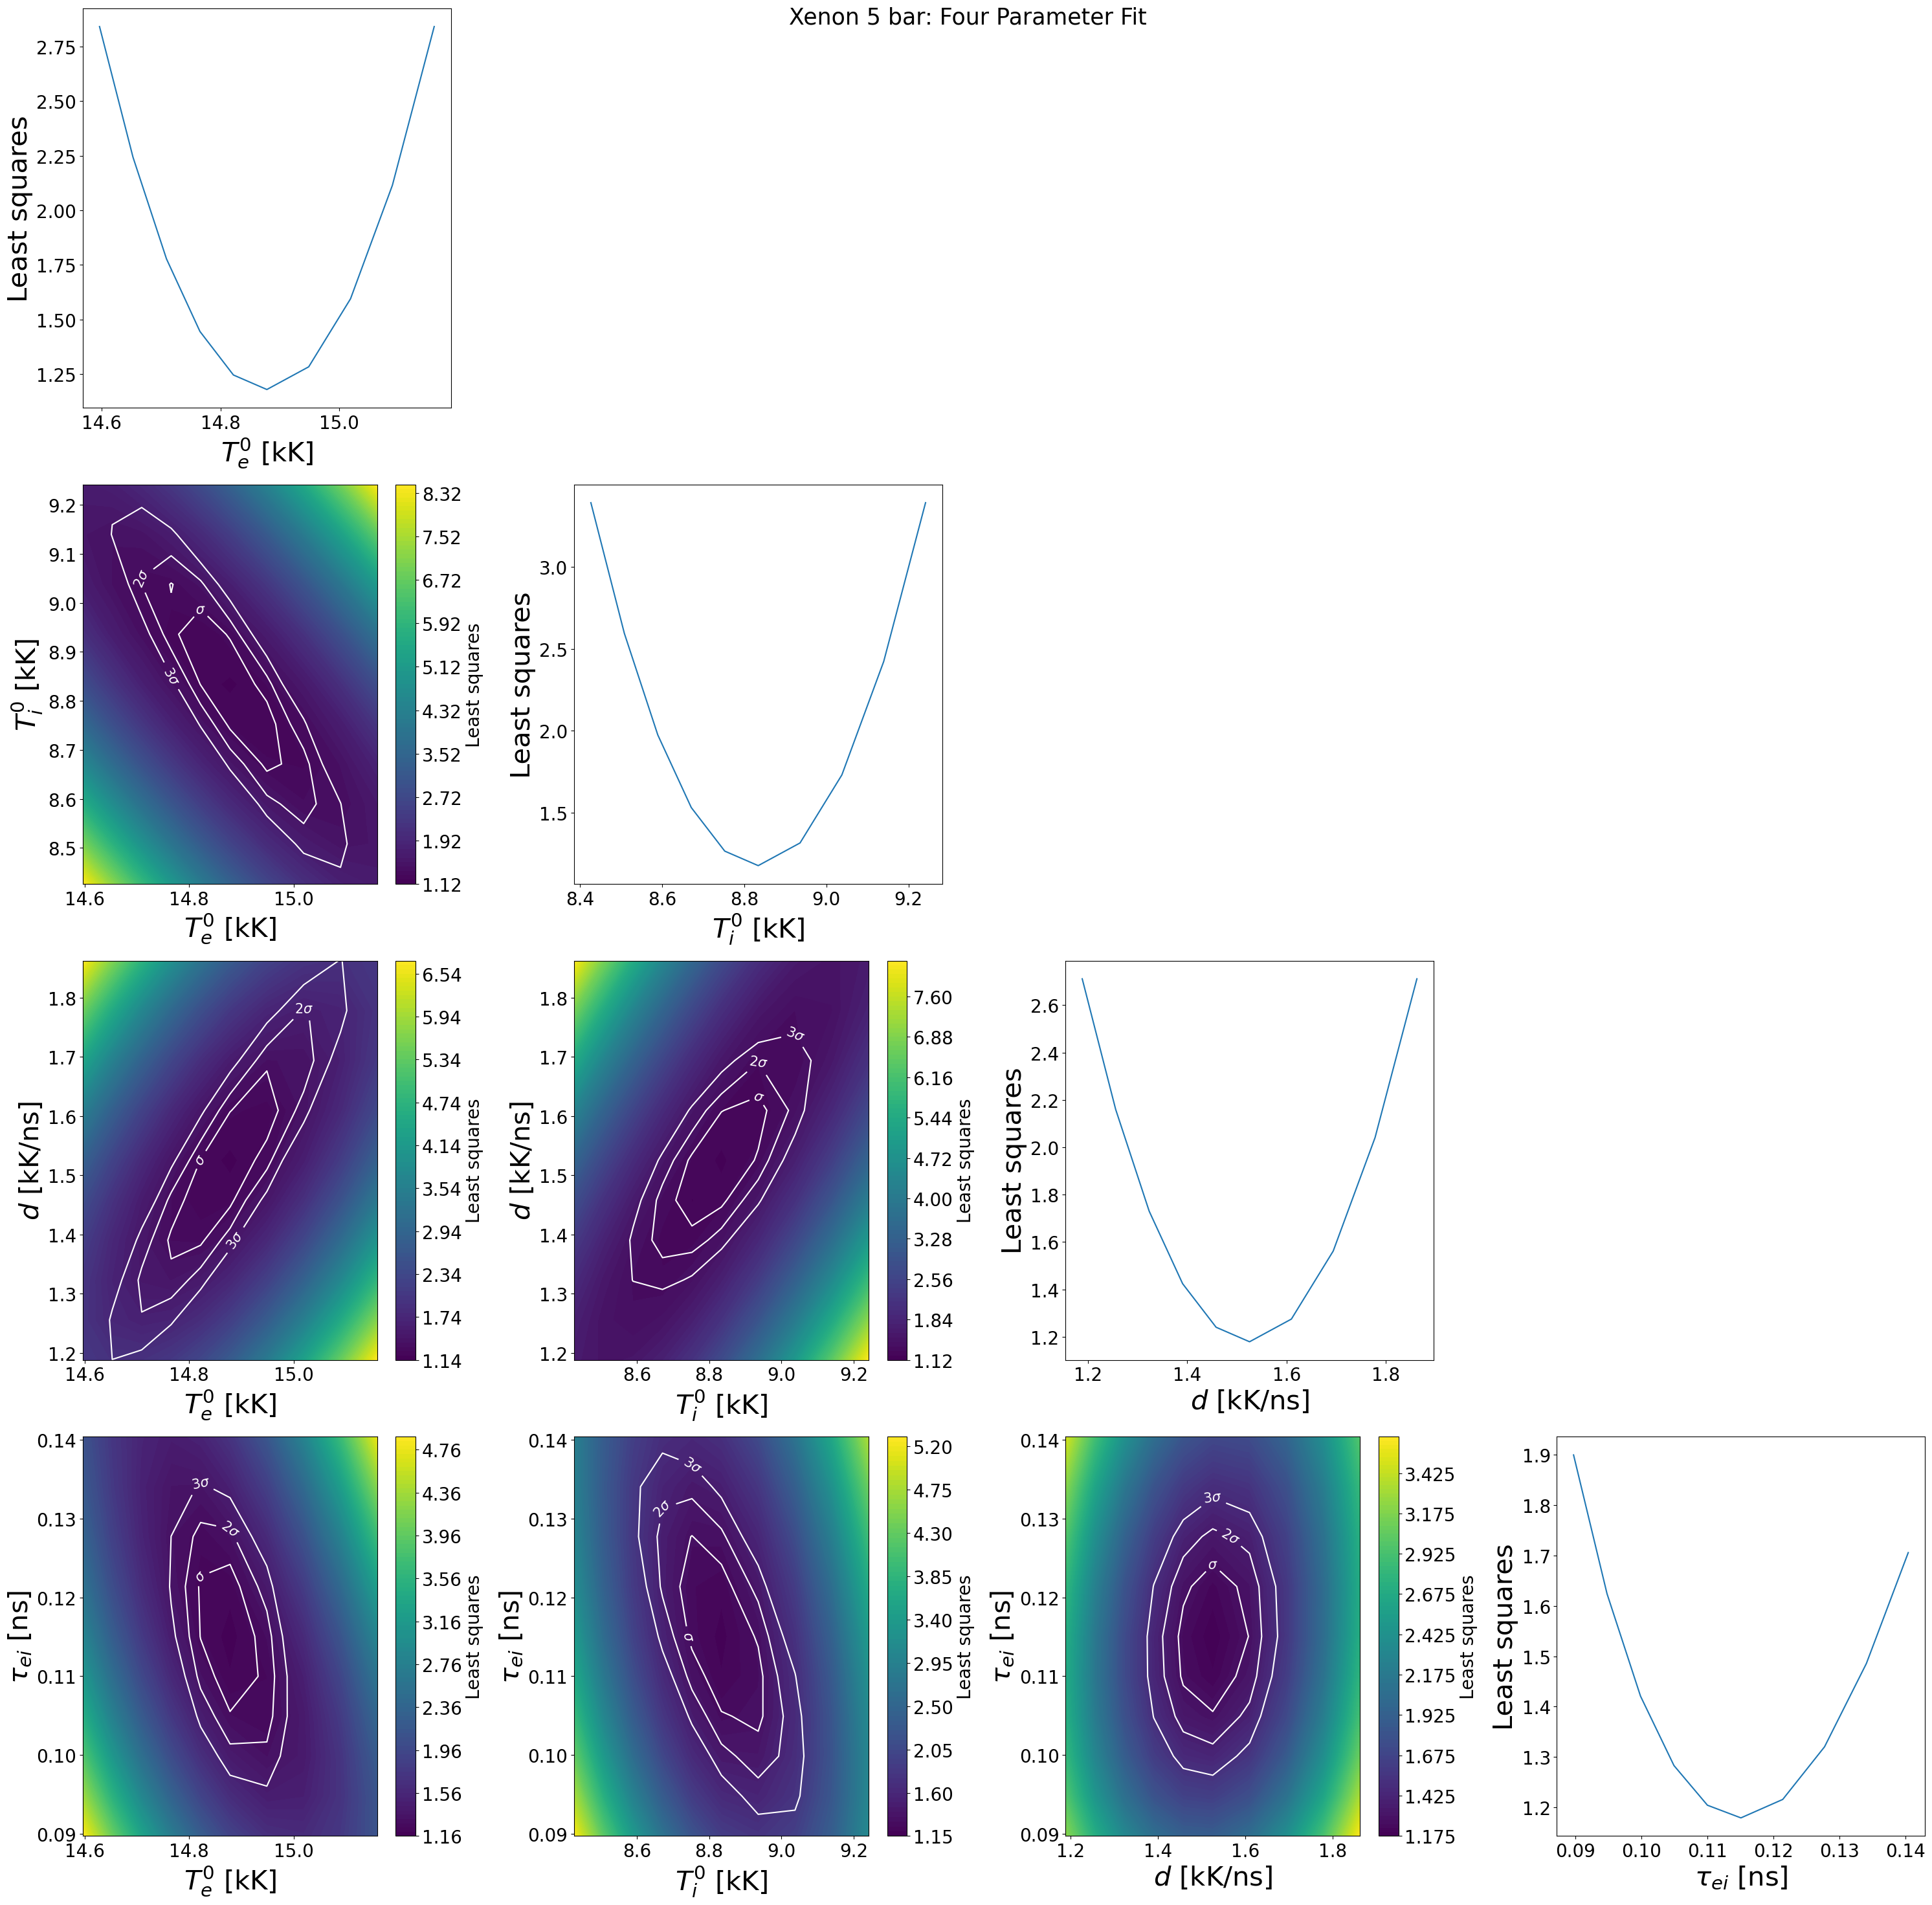

In [36]:
model1.make_least_squares_grid(N=10)
model1.plot_all_slices()

# Model 2 (Six Parameters)
Include specific heats, and each species loses energy at the same rate

\begin{align}
c_e \dot{T_e} &= - G (T_e - T_i) - S \\
c_i \dot{T_i} &= + G (T_e - T_i) - S
\end{align}


In [200]:
def T_model_2(t, Te_0, Ti_0, G, S, ce, ci):
    """
    Args: 
        Te_0: Electron Initial Temperature [kK]
        Ti_0: Ion Initial Temperature [kK]
        G: Electron-Ion Coupling []
        S: 
        ce: Electron heat Capacity [J/K/m^3]
        ci: Ion heat Capacity [J/kK/m^3]
        
    """
    ΔT0 = (Te_0-Ti_0)
    Σ_tilde_T0 = (ce*Te_0+ci*Ti_0)/(ce+ci)
    
    Σ_tilde_T = Σ_tilde_T0 - (2*S)/(ce+ci) * t
    ΔT = ΔT0 * np.exp(-t*G*(1/ce + 1/ci))
    
    Te = (ΔT + (ce+ci)*Σ_tilde_T/ci)/(1+ce/ci)
    return Te


def T_model_3(t, Te_0, Ti_0, d, τei, τie):
    """
    Args: 
        Te_0: Electron Initial Temperature [kK]
        Ti_0: Ion Initial Temperature [kK]
        G: Electron-Ion Coupling []
        S: 
        ce: Electron heat Capacity [J/K/m^3]
        ci: Ion heat Capacity [J/kK/m^3]
        
    """
    ΔT0 = (Te_0-Ti_0)
    νei, νie = 1/τei, 1/τie
    Σ_tilde_T0 = (Te_0*νie + Ti_0*νei)/(νei + νie)
    
    Σ_tilde_T = Σ_tilde_T0 - d * t
    ΔT = ΔT0 * np.exp(-t*(νei + νie))
    
    Te = (ΔT + (νei+νie)*Σ_tilde_T/νei)/(1+νie/νei)
    return Te



In [207]:
16, 9, G_guess/1e7, S_guess/1e6, ce_guess/1e7, ci_guess/1e7

(16, 9, 0.4968, 1.863, 1.242, 1.242)

In [201]:
ce_guess = 3/2 * (6e26) * k_B*1e3 # J/kK/m^3
ci_guess = ce_guess
τ_guess  = 2.5 # ns
G_guess  = ce_guess/τ_guess # J/kK/ns/m^3
dTdt_lin_guess    = 0.15 # kK/ns 
S_guess  = dTdt_lin_guess*ce_guess

model2 = FitAnalysis(Xe_data, T_model_2, fit_guess = (16, 9, G_guess, S_guess, ce_guess, ci_guess ) )
model3 = FitAnalysis(Xe_data, T_model_3, fit_guess = (16, 9, dTdt_lin_guess, τ_guess, τ_guess ) )

Fit values: 
╒══════════╤══════════╤════════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│          │     Te_0 │       Ti_0 │         G │         S │        ce │        ci │
╞══════════╪══════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Best Fit │ 16.64    │      9.647 │ 1.063e+07 │ 3.31e+06  │ 2.474e+07 │ 2.715e+07 │
├──────────┼──────────┼────────────┼───────────┼───────────┼───────────┼───────────┤
│ σ        │  0.05906 │ 915700     │ 7.584e+11 │ 2.217e+11 │ 4.29e+12  │ 3.555e+12 │
╘══════════╧══════════╧════════════╧═══════════╧═══════════╧═══════════╧═══════════╛
Covariance values: 
╒══════╤═════════════╤═════════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│      │        Te_0 │        Ti_0 │         G │         S │        ce │        ci │
╞══════╪═════════════╪═════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Te_0 │    0.00349  │ 1140        │  8.38e+08 │  3.14e+08 │ -2.08e+09 │  7e+09    │
├──────┼─────────────┼──────────

In [204]:
model3.make_least_squares_grid(N=10)

/tmp/ipykernel_5846/2896115987.py:104: UserWarning: No contour levels were found within the data range.
  confidence_contours = plt.contour(param1_range, param2_range, -2*np.log(pdf_slice.T), colors='w', levels=chi_square_vals)
/tmp/ipykernel_5846/2896115987.py:104: UserWarning: No contour levels were found within the data range.
  confidence_contours = plt.contour(param1_range, param2_range, -2*np.log(pdf_slice.T), colors='w', levels=chi_square_vals)
/tmp/ipykernel_5846/2896115987.py:104: UserWarning: No contour levels were found within the data range.
  confidence_contours = plt.contour(param1_range, param2_range, -2*np.log(pdf_slice.T), colors='w', levels=chi_square_vals)
/tmp/ipykernel_5846/2896115987.py:104: UserWarning: No contour levels were found within the data range.
  confidence_contours = plt.contour(param1_range, param2_range, -2*np.log(pdf_slice.T), colors='w', levels=chi_square_vals)


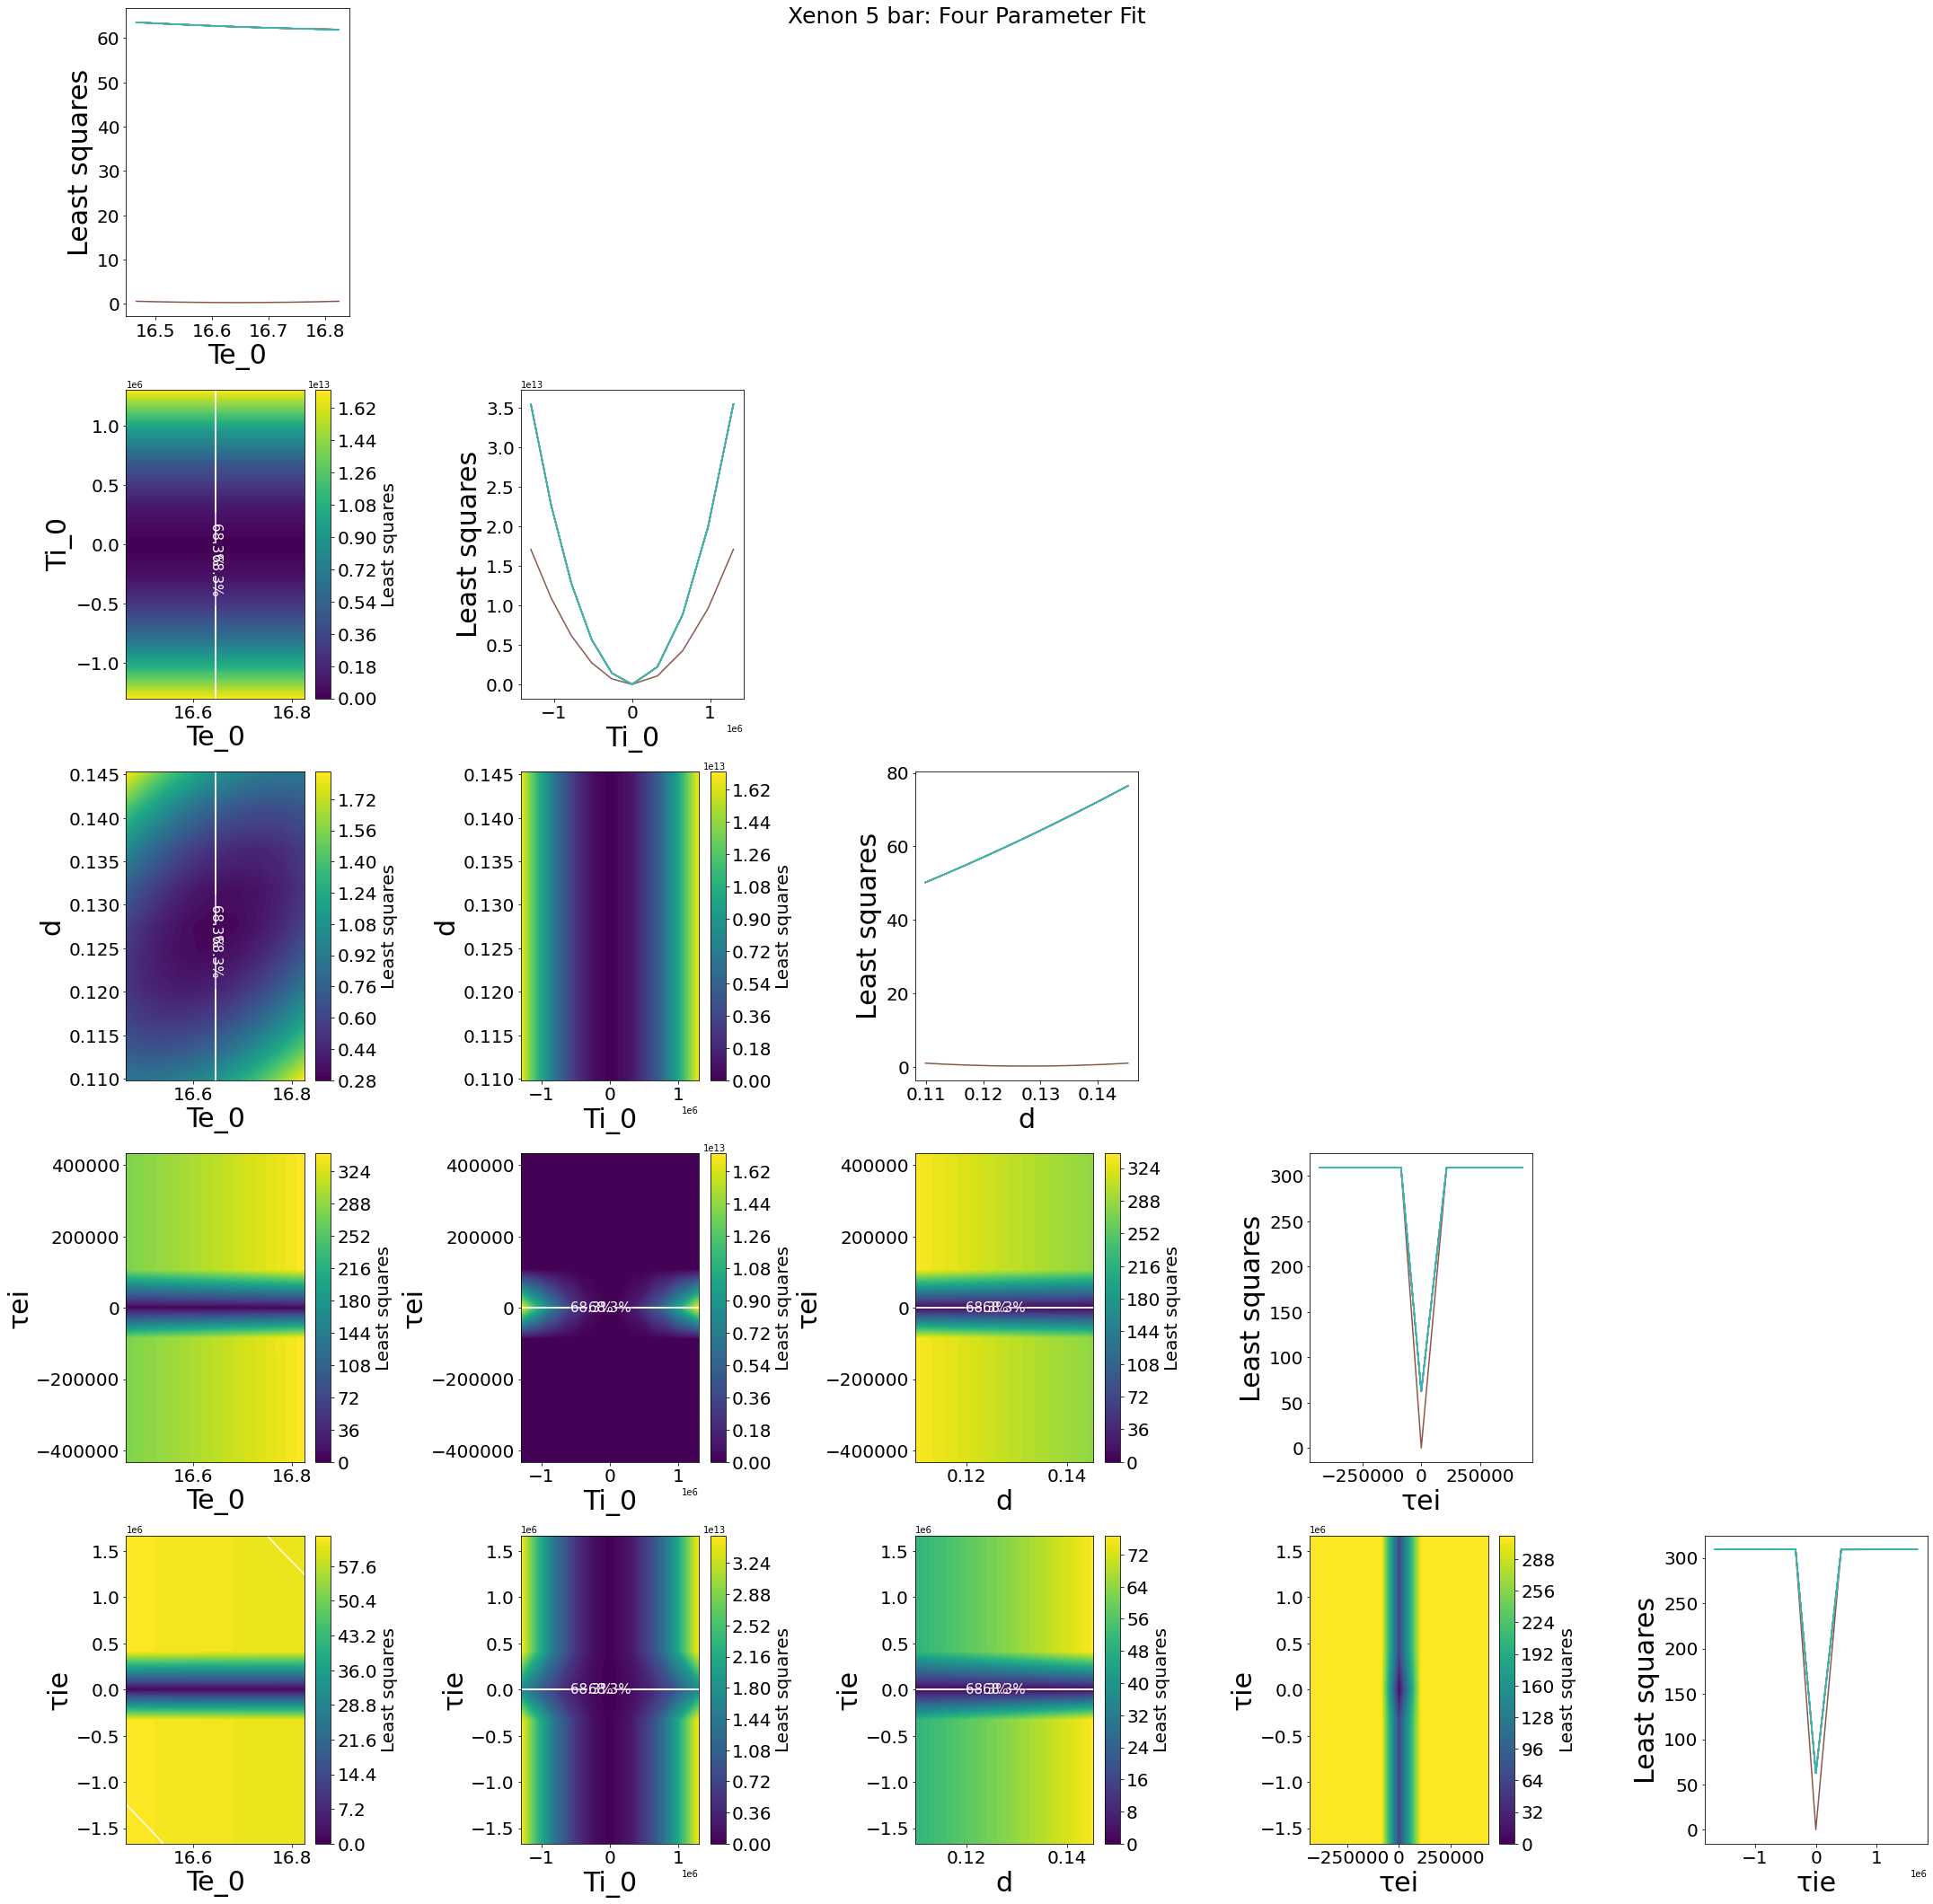

In [205]:
model3.plot_all_slices()